## Model: Prophet and LSTM
#### Steps:
- Load data
- Exploratory data analysis
- Training Model
- Tuning Parameter
- MAPE and RMSE Summary

In [47]:
import pandas as pd
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [274]:
train = pd.read_csv("zillow-carlifornia.csv")
test = pd.read_csv("test.csv")

In [3]:
print(train.shape)
print(train.columns)
train.sample(5)

(107, 4)
Index(['Date', 'MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')


,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
36,2011-02-28,345000.0,4.08,8.1
51,2012-05-31,360250.0,3.78,7.5
75,2014-05-31,450000.0,4.21,7.3
3,2008-05-31,429000.0,5.47,6.3


In [5]:
print(test.shape)
print(test.columns)
test.sample(5)

(12, 2)
Index(['Month', 'Median House Price'], dtype='object')


,Month,Median House Price
3,2016-04-30,501000
10,2016-11-30,506000
11,2016-12-31,510000
9,2016-10-31,523000
7,2016-08-31,510000


In [26]:
train_1 = train[['Date', 'MedianSoldPrice_AllHomes.California']][:-12]
train_1.tail()

,Date,MedianSoldPrice_AllHomes.California
90,2015-08-31,475000.0
91,2015-09-30,470000.0
92,2015-10-31,470000.0
93,2015-11-30,485750.0
94,2015-12-31,485000.0


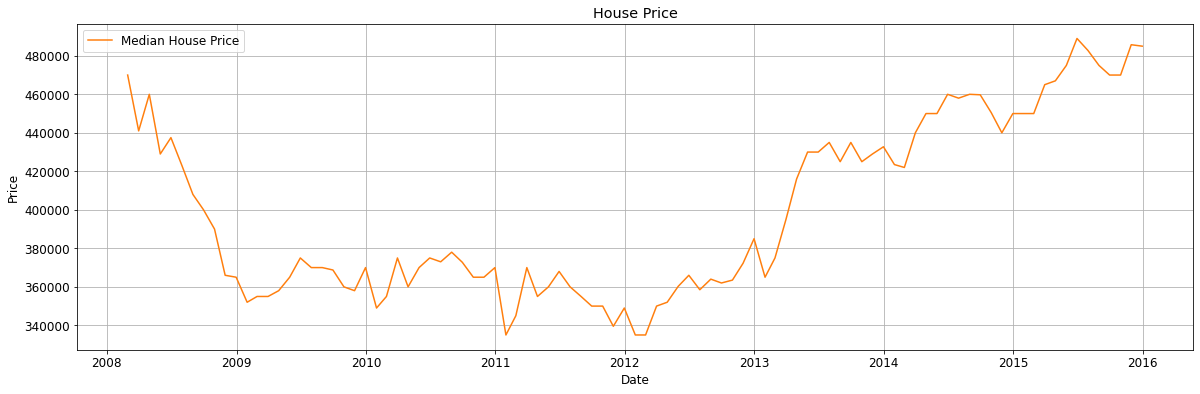

In [27]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(train_1.Date, train_1['MedianSoldPrice_AllHomes.California'], color='tab:orange', label='Median House Price')

# Same as above

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('House Price')
ax.grid(True)
ax.legend(loc='upper left');

In [28]:
train_1=train_1.rename(columns={"Date": "ds", "MedianSoldPrice_AllHomes.California": "y"})

## Basic Prophet

In [232]:
train_2 = train_1[:-12]
test_2 = train_1[-12:]
m = Prophet()
m.fit(train_2)
prediction_size = 12
future = m.make_future_dataframe(periods=prediction_size, freq='M')
forecast = m.predict(future)
print(np.sqrt(mean_squared_error(forecast[-12:]['yhat'], test_2['y'])))
mean_absolute_percentage_error(forecast[-12:]['yhat'], test_2['y'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7388.590463349092


0.0124057988258707

## Add Seasonality

In [235]:
train_2 = train_1[:-12]
test_2 = train_1[-12:]
m = Prophet().add_seasonality(name='monthly', period=12, fourier_order=5)
m.fit(train_2)
prediction_size = 12
future = m.make_future_dataframe(periods=prediction_size, freq='M')
forecast = m.predict(future)
print(np.sqrt(mean_squared_error(forecast[-12:]['yhat'], test_2['y'])))
mean_absolute_percentage_error(forecast[-12:]['yhat'], test_2['y'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8985.215493581816


0.016645198947699044

## Add Holiday

In [236]:
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2016, 2017, 2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [238]:
train_2 = train_1[:-12]
test_2 = train_1[-12:]
m = Prophet(holidays=holiday)
m = m.add_seasonality(name='monthly', period=12, fourier_order=5)
m.fit(train_2)
prediction_size = 12
future = m.make_future_dataframe(periods=prediction_size, freq='M')
forecast = m.predict(future)
print(np.sqrt(mean_squared_error(forecast[-12:]['yhat'], test_2['y'])))
mean_absolute_percentage_error(forecast[-12:]['yhat'], test_2['y'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8985.217220178421


0.016645202288501058

## Fit on the whole dataset and check the test results

In [29]:
m = Prophet()
m.fit(train_1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
prediction_size = 12
future = m.make_future_dataframe(periods=prediction_size, freq='M')
forecast = m.predict(future)

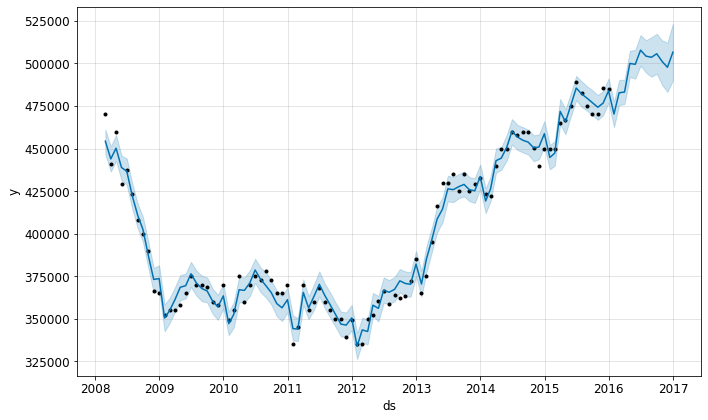

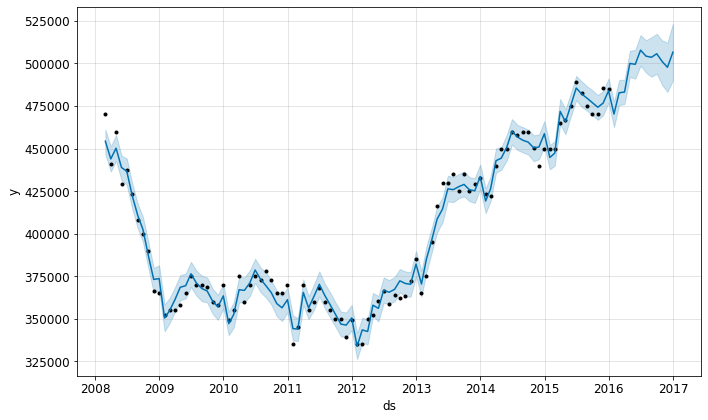

In [39]:
m.plot(forecast)

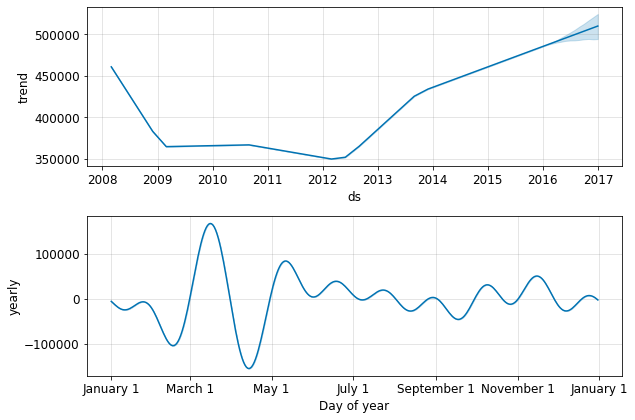

In [40]:
fig2 = m.plot_components(forecast)

In [44]:
forecast[-12:][['ds','yhat']]

,ds,yhat
95,2016-01-31,470275.492860
96,2016-02-29,482762.505487
97,2016-03-31,483201.925828
98,2016-04-30,499996.520476
99,2016-05-31,499497.216743
100,2016-06-30,507826.090492
101,2016-07-31,504308.463738
102,2016-08-31,503624.267886
103,2016-09-30,505718.133828
104,2016-10-31,501148.458247


In [22]:
test

,Month,Median House Price
0,2016-01-31,476250
1,2016-02-29,466000
2,2016-03-31,485000
3,2016-04-30,501000
4,2016-05-31,501000
5,2016-06-30,505000
6,2016-07-31,507000
7,2016-08-31,510000
8,2016-09-30,510000
9,2016-10-31,523000


In [52]:
np.sqrt(mean_squared_error(forecast[-12:]['yhat'], test['Median House Price']))

8919.060048160085

In [53]:
mean_absolute_percentage_error(forecast[-12:]['yhat'], test['Median House Price'])

0.012921784283725231

In [281]:
forecast[-12:].reset_index()[['yhat']].round(2)

,yhat
0,445537.61
1,446583.25
2,467789.99
3,461561.39
4,479635.83
5,474002.58
6,478357.38
7,488899.62
8,477438.63
9,478636.08


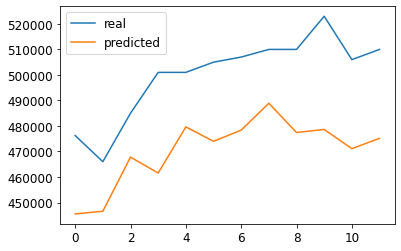

In [276]:
plt.plot(test['Median House Price'], label='real')
plt.plot(forecast[-12:]['yhat'].reset_index()['yhat'], label='predicted')
plt.legend()
plt.show()

## LSTM

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import warnings
from math import sqrt

In [60]:
train = pd.read_csv('zillow-carlifornia.csv',header=0, index_col="Date", parse_dates=True, squeeze=True)
test = pd.read_csv('test.csv',header=0, index_col="Month", parse_dates=True, squeeze=True)
train.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [142]:
len(train)

94

In [70]:
test.head()

Month
2016-01-31    476250
2016-02-29    466000
2016-03-31    485000
2016-04-30    501000
2016-05-31    501000
Name: Median House Price, dtype: int64

In [73]:
train_lstm = train[['MedianSoldPrice_AllHomes.California','MedianMortageRate', 'UnemploymentRate']]

In [300]:
train_lstm.iloc[-13]

MedianSoldPrice_AllHomes.California    485000.00
MedianMortageRate                           3.89
UnemploymentRate                            5.10
Name: 2015-12-31 00:00:00, dtype: float64

In [89]:
test_lstm = pd.concat([test, train_lstm[-12:][['MedianMortageRate', 'UnemploymentRate']]], axis=1)

,Median House Price,MedianMortageRate,UnemploymentRate
2016-01-31,476250,3.91,5.0
2016-02-29,466000,3.96,4.9
2016-03-31,485000,3.60,5.0
2016-04-30,501000,3.60,5.0
2016-05-31,501000,3.59,4.8
2016-06-30,505000,3.59,4.8
2016-07-31,507000,3.46,4.9
2016-08-31,510000,3.46,4.8
2016-09-30,510000,3.42,5.0
2016-10-31,523000,3.36,5.0


In [311]:
df2 = pd.DataFrame([[485000.00,3.89,5.10]], columns=['Median House Price','MedianMortageRate','UnemploymentRate'], index = ['2015-12-31 00:00:00'])
test_lstm = pd.concat([df2, test_lstm])

In [312]:
#Step 1: framing the dataset as a supervised learning problem and normalizing the input variables.
##### a. input: tempurature and beer consumption in previous day
####     output: beer consumption on current day

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [313]:
train_values = train_lstm.values
test_values = test_lstm.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.fit_transform(test_values)

In [314]:
train_reframed = series_to_supervised(train_scaled, 1, 1) 
test_reframed = series_to_supervised(test_scaled, 1, 1) 

print(train_reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.876623   0.729927   0.363636  0.688312  0.784672  0.340909
2   0.688312   0.784672   0.340909  0.811688  0.777372  0.386364
3   0.811688   0.777372   0.386364  0.610390  0.795620  0.363636
4   0.610390   0.795620   0.363636  0.665584  0.843066  0.340909
5   0.665584   0.843066   0.340909  0.571429  0.956204  0.204545


In [315]:
# drop column we don't want to predict, aka weather
train_reframed.drop(train_reframed.columns[[4, 5]], axis=1, inplace=True)
test_reframed.drop(test_reframed.columns[[4, 5]], axis=1, inplace=True)

print(train_reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.876623   0.729927   0.363636  0.688312
2   0.688312   0.784672   0.340909  0.811688
3   0.811688   0.777372   0.386364  0.610390
4   0.610390   0.795620   0.363636  0.665584
5   0.665584   0.843066   0.340909  0.571429


## Train and Valid

In [145]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from numpy import concatenate

In [208]:
result = {}
for batch_size in [1, 3, 6, 12]: 
    for hidden_layer in [8, 16, 24, 32]:
        train = train_reframed[:-12].values
        test = train_reframed[-12:].values
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(hidden_layer, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae')
        history = model.fit(train_X, train_y, epochs=100, batch_size=3, validation_data=(test_X, test_y))
        # make a prediction
        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        # invert scaling for forecast
        inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate mape
        mape=(np.abs(np.array(inv_y)-np.array(inv_yhat))/np.array(inv_y)).mean()
        rmse = np.sqrt(mean_squared_error(inv_yhat, inv_y))
        result[(batch_size, hidden_layer)] = (mape, rmse)

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2973 - val_loss: 0.7567
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2199 - val_loss: 0.6880
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1899 - val_loss: 0.6295
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1769 - val_loss: 0.5980
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1701 - val_loss: 0.5646
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1631 - val_loss: 0.5559
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1585 - val_loss: 0.5260
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1517 - val_loss: 0.5017
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1457 - val_loss: 0.4777
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1389 - val_loss: 0.4496
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2951 - val_loss: 0.8677
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2309 - val_loss: 0.7855
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2091 - val_loss: 0.7320
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1985 - val_loss: 0.6939
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1896 - val_loss: 0.6695
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1811 - val_loss: 0.6253
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1726 - val_loss: 0.6009
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1642 - val_loss: 0.5664
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1546 - val_loss: 0.5144
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1443 - val_loss: 0.4687
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2914 - val_loss: 0.7705
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2046 - val_loss: 0.6851
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1876 - val_loss: 0.6325
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1740 - val_loss: 0.5647
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1661 - val_loss: 0.5522
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1548 - val_loss: 0.5015
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1425 - val_loss: 0.4565
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1313 - val_loss: 0.3824
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1188 - val_loss: 0.3566
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1066 - val_loss: 0.3035
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2395 - val_loss: 0.7851
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2046 - val_loss: 0.7116
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1909 - val_loss: 0.6573
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1803 - val_loss: 0.6334
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1692 - val_loss: 0.5777
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1580 - val_loss: 0.5290
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1460 - val_loss: 0.4712
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1339 - val_loss: 0.4373
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1221 - val_loss: 0.3619
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1060 - val_loss: 0.2982
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.3362 - val_loss: 0.8264
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2577 - val_loss: 0.7482
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2121 - val_loss: 0.6869
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1898 - val_loss: 0.6397
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1796 - val_loss: 0.5958
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1742 - val_loss: 0.5867
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1701 - val_loss: 0.5650
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1663 - val_loss: 0.5427
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1624 - val_loss: 0.5326
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1587 - val_loss: 0.5108
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2974 - val_loss: 0.7278
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2014 - val_loss: 0.6425
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1722 - val_loss: 0.5710
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1603 - val_loss: 0.5198
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1530 - val_loss: 0.5001
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1452 - val_loss: 0.4726
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1374 - val_loss: 0.4353
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1279 - val_loss: 0.4220
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1211 - val_loss: 0.3783
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1126 - val_loss: 0.3223
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.3682 - val_loss: 0.8238
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2464 - val_loss: 0.7107
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1943 - val_loss: 0.6501
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1794 - val_loss: 0.5836
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1697 - val_loss: 0.5371
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1600 - val_loss: 0.5018
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1503 - val_loss: 0.4654
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1391 - val_loss: 0.4225
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1284 - val_loss: 0.3691
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1165 - val_loss: 0.3058
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2739 - val_loss: 0.7346
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1948 - val_loss: 0.6474
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1778 - val_loss: 0.5973
Epoch 4/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1673 - val_loss: 0.5592
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1570 - val_loss: 0.5081
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1457 - val_loss: 0.4379
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1328 - val_loss: 0.4060
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1216 - val_loss: 0.3717
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1089 - val_loss: 0.2884
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.0998 - val_loss: 0.2422
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2589 - val_loss: 0.6884
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1918 - val_loss: 0.6153
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1673 - val_loss: 0.5786
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1593 - val_loss: 0.5526
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1531 - val_loss: 0.5196
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1472 - val_loss: 0.4903
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1421 - val_loss: 0.4701
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1361 - val_loss: 0.4410
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1293 - val_loss: 0.4222
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1231 - val_loss: 0.3960
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.3070 - val_loss: 0.7916
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2203 - val_loss: 0.7167
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1918 - val_loss: 0.6709
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1834 - val_loss: 0.6303
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1775 - val_loss: 0.6134
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1722 - val_loss: 0.5831
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1664 - val_loss: 0.5560
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1600 - val_loss: 0.5321
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1524 - val_loss: 0.4995
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1462 - val_loss: 0.4597
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2719 - val_loss: 0.7632
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2004 - val_loss: 0.6722
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1800 - val_loss: 0.6044
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1716 - val_loss: 0.5844
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1620 - val_loss: 0.5441
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1508 - val_loss: 0.4907
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1404 - val_loss: 0.4455
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1295 - val_loss: 0.4029
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1165 - val_loss: 0.3588
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1038 - val_loss: 0.2734
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2724 - val_loss: 0.6750
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1772 - val_loss: 0.5525
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1598 - val_loss: 0.5044
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1483 - val_loss: 0.4644
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1378 - val_loss: 0.4195
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1272 - val_loss: 0.3992
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1164 - val_loss: 0.3302
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1074 - val_loss: 0.2934
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.0968 - val_loss: 0.2294
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.0874 - val_loss: 0.1991
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2900 - val_loss: 0.8793
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2381 - val_loss: 0.8221
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2167 - val_loss: 0.7871
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2088 - val_loss: 0.7512
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.2013 - val_loss: 0.7313
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1961 - val_loss: 0.7075
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1902 - val_loss: 0.6811
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1839 - val_loss: 0.6500
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1778 - val_loss: 0.6372
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1718 - val_loss: 0.6064
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2808 - val_loss: 0.7552
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2028 - val_loss: 0.6722
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1784 - val_loss: 0.6177
Epoch 4/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1684 - val_loss: 0.5625
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1605 - val_loss: 0.5412
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1516 - val_loss: 0.5142
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1412 - val_loss: 0.4889
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1322 - val_loss: 0.4239
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1186 - val_loss: 0.3615
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1104 - val_loss: 0.3390
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2424 - val_loss: 0.6988
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1823 - val_loss: 0.6203
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.5753
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1563 - val_loss: 0.5172
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1464 - val_loss: 0.4857
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1358 - val_loss: 0.4302
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1249 - val_loss: 0.3932
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1156 - val_loss: 0.3519
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1055 - val_loss: 0.2949
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 0.0974 - val_loss: 0.2540
Epoch 11

Epoch 1/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2475 - val_loss: 0.6853
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1807 - val_loss: 0.6163
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1702 - val_loss: 0.5771
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1607 - val_loss: 0.5299
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.1503 - val_loss: 0.4748
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1379 - val_loss: 0.4533
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1278 - val_loss: 0.3901
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 0.1135 - val_loss: 0.3375
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 0.0992 - val_loss: 0.2527
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.2142
Epoch 11

In [218]:
print('batch_size hidden_layer   mape         rmse')
for k, v in sorted(result.items(), key=lambda item: item[1][1]):
    print(f'{k[0]:>6} {k[1]:>10} {round(v[0],4) :>13} {int(v[1]) :>11}')

batch_size hidden_layer   mape         rmse
     6         32        0.0047        2953
     6         24        0.0047        3001
    12         32        0.0046        3035
    12         24        0.0047        3221
     3          8        0.0047        3446
     6         16        0.0049        3448
    12         16        0.0051        3630
     1         24        0.0053        3695
     1          8        0.0051        3727
     3         32        0.0055        3772
     3         16        0.0055        3940
     1         32        0.0059        3993
     3         24        0.0059        4036
     6          8        0.0074        4819
     1         16         0.008        5105
    12          8        0.0111        6497
